<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Caltech-256-128/resized/15*15/caltech256_15_15_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/caltech-256-image-aspect-preserved-128.zip -d caltech-256-image-aspect-preserved-128

Streaming output truncated to the last 5000 lines.
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0001.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0248.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0644.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0768.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0404.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0303.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0109.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0122.jpg  
  inflating: caltech-

In [4]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 257
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 64
DATA_DIRECTORY = "caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/"

In [5]:
filenames = os.listdir(DATA_DIRECTORY)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [7]:
print(train_df.shape)
print(validate_df.shape)

(24485, 2)
(6122, 2)


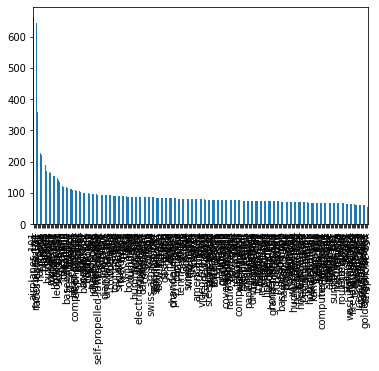

In [8]:
train_df['category'].value_counts().plot.bar()

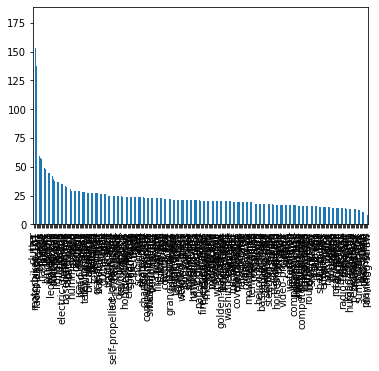

In [9]:
validate_df['category'].value_counts().plot.bar()

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 24485 validated image filenames belonging to 257 classes.


In [11]:
validation_datagen = ImageDataGenerator(
    # fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6122 validated image filenames belonging to 257 classes.


In [12]:
train_generator.image_shape

(128, 128, 3)

In [13]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

257


In [14]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# classifier = None
# classifier = Sequential([
#     layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# classifier = None
# classifier = Sequential([
#     layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.01),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.01),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.01),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dropout(0.01),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# classifier = None
# classifier = Sequential([
#     layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.1),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.1),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.1),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dropout(0.1),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# classifier = None
# classifier = Sequential([
#     layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=train_generator.image_shape),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.1),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.1),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#         layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#         layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.1),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#         layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#         layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dropout(0.1),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.1),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

classifier = None
classifier = Sequential([
    layers.Conv2D(64, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=train_generator.image_shape),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
        layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
        layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
        layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
        layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
        layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(4096),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Dense(4096),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


# classifier = None
# classifier = Sequential([
#     Conv2D(64, (3, 3), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), padding='same',
#            activation='relu'),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     Conv2D(128, (3, 3), activation='relu', padding='same',),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
#     Conv2D(256, (3, 3), activation='relu', padding='same',),
#     Conv2D(256, (3, 3), activation='relu', padding='same',),
#     Conv2D(256, (3, 3), activation='relu', padding='same',),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
#     Flatten(),
#     Dense(4096, activation='relu'),
#     Dense(4096, activation='relu'),
#     Dense(NUM_CLASSES, activation='softmax')
# ])


# classifier = None
# classifier = Sequential([
#     layers.Conv2D(64, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=train_generator.image_shape),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.1),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.1),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#         layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#         layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.1),
#     layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#         layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#         layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#         layers.Dropout(0.1),
#     layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#         layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#         layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dropout(0.1),
#     layers.Dense(4096),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.1),
#     layers.Dense(4096),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

classifier.summary()

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      43264     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 156s 194ms/step - loss: 6.8765 - accuracy: 0.0335 - auc: 0.5669 - val_loss: 9.1701 - val_accuracy: 0.0229 - val_auc: 0.5464
Epoch 2/1000
765/765 [==============================] - 147s 192ms/step - loss: 5.6420 - accuracy: 0.0526 - auc: 0.6251 - val_loss: 5.2120 - val_accuracy: 0.0643 - val_auc: 0.6346
Epoch 3/1000
765/765 [==============================] - 146s 191ms/step - loss: 5.3007 - accuracy: 0.0673 - auc: 0.6663 - val_loss: 5.3449 - val_accuracy: 0.0800 - val_auc: 0.7098
Epoch 4/1000
765/765 [==============================] - 146s 190ms/step - loss: 4.9416 - accuracy: 0.0830 - auc: 0.7117 - val_loss: 4.8606 - val_accuracy: 0.0902 - val_auc: 0.7254
Epoch 5/1000
765/765 [==============================] - 146s 191ms/step - loss: 4.7850 - accuracy: 0.0929 - auc: 0.7338 - val_loss: 4.8779 - val_accuracy: 0.0924 - val_auc: 0.7343
Epoch 6/1000
765/765 [==============================] - 145s 190ms/step - loss: 4.7668 - accuracy: 0

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 149s 185ms/step - loss: 6.7986 - accuracy: 0.0319 - auc: 0.5646 - val_loss: 9.0729 - val_accuracy: 0.0298 - val_auc: 0.5863
Epoch 2/1000
765/765 [==============================] - 141s 185ms/step - loss: 5.9750 - accuracy: 0.0533 - auc: 0.6368 - val_loss: 5.4707 - val_accuracy: 0.0545 - val_auc: 0.6461
Epoch 3/1000
765/765 [==============================] - 141s 185ms/step - loss: 5.3887 - accuracy: 0.0644 - auc: 0.6643 - val_loss: 4.9758 - val_accuracy: 0.0797 - val_auc: 0.7056
Epoch 4/1000
765/765 [==============================] - 141s 184ms/step - loss: 5.0191 - accuracy: 0.0794 - auc: 0.6967 - val_loss: 7.6894 - val_accuracy: 0.0476 - val_auc: 0.6360
Epoch 5/1000
765/765 [==============================] - 141s 185ms/step - loss: 4.9210 - accuracy: 0.0862 - auc: 0.7076 - val_loss: 4.8817 - val_accuracy: 0.0920 - val_auc: 0.7159
Epoch 6/1000
765/765 [==============================] - 141s 185ms/step - loss: 4.8014 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 134s 173ms/step - loss: 5.4380 - accuracy: 0.0528 - auc: 0.6106 - val_loss: 5.7412 - val_accuracy: 0.0556 - val_auc: 0.6397
Epoch 2/1000
765/765 [==============================] - 132s 173ms/step - loss: 4.9401 - accuracy: 0.0841 - auc: 0.7014 - val_loss: 4.9938 - val_accuracy: 0.0934 - val_auc: 0.7064
Epoch 3/1000
765/765 [==============================] - 133s 173ms/step - loss: 4.6561 - accuracy: 0.1093 - auc: 0.7472 - val_loss: 4.8375 - val_accuracy: 0.1014 - val_auc: 0.7280
Epoch 4/1000
765/765 [==============================] - 133s 173ms/step - loss: 4.4621 - accuracy: 0.1270 - auc: 0.7778 - val_loss: 4.4879 - val_accuracy: 0.1376 - val_auc: 0.7709
Epoch 5/1000
765/765 [==============================] - 132s 173ms/step - loss: 4.2537 - accuracy: 0.1534 - auc: 0.8040 - val_loss: 4.2119 - val_accuracy: 0.1612 - val_auc: 0.8047
Epoch 6/1000
765/765 [==============================] - 132s 172ms/step - loss: 4.0780 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 117s 146ms/step - loss: 5.4620 - accuracy: 0.0535 - auc: 0.6065 - val_loss: 5.8935 - val_accuracy: 0.0695 - val_auc: 0.6642
Epoch 2/1000
765/765 [==============================] - 111s 145ms/step - loss: 4.8661 - accuracy: 0.0930 - auc: 0.7131 - val_loss: 5.2617 - val_accuracy: 0.0895 - val_auc: 0.6804
Epoch 3/1000
765/765 [==============================] - 117s 153ms/step - loss: 4.6230 - accuracy: 0.1150 - auc: 0.7524 - val_loss: 4.6858 - val_accuracy: 0.1014 - val_auc: 0.7555
Epoch 4/1000
765/765 [==============================] - 114s 149ms/step - loss: 4.3699 - accuracy: 0.1404 - auc: 0.7882 - val_loss: 4.5006 - val_accuracy: 0.1304 - val_auc: 0.7732
Epoch 5/1000
765/765 [==============================] - 112s 146ms/step - loss: 4.1990 - accuracy: 0.1555 - auc: 0.8098 - val_loss: 4.7028 - val_accuracy: 0.1319 - val_auc: 0.7475
Epoch 6/1000
765/765 [==============================] - 110s 144ms/step - loss: 4.0248 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 127s 158ms/step - loss: 5.3551 - accuracy: 0.0660 - auc: 0.6277 - val_loss: 5.4632 - val_accuracy: 0.0663 - val_auc: 0.6680
Epoch 2/1000
765/765 [==============================] - 119s 155ms/step - loss: 4.6656 - accuracy: 0.1091 - auc: 0.7472 - val_loss: 4.8351 - val_accuracy: 0.1111 - val_auc: 0.7349
Epoch 3/1000
765/765 [==============================] - 122s 160ms/step - loss: 4.3436 - accuracy: 0.1439 - auc: 0.7908 - val_loss: 6.4249 - val_accuracy: 0.0756 - val_auc: 0.6533
Epoch 4/1000
765/765 [==============================] - 123s 161ms/step - loss: 4.0848 - accuracy: 0.1688 - auc: 0.8270 - val_loss: 4.1505 - val_accuracy: 0.1860 - val_auc: 0.8098
Epoch 5/1000
765/765 [==============================] - 124s 162ms/step - loss: 3.8846 - accuracy: 0.1942 - auc: 0.8433 - val_loss: 3.8326 - val_accuracy: 0.2171 - val_auc: 0.8399
Epoch 6/1000
765/765 [==============================] - 121s 158ms/step - loss: 3.5317 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 116s 149ms/step - loss: 5.4089 - accuracy: 0.0542 - auc: 0.6210 - val_loss: 8.5766 - val_accuracy: 0.0409 - val_auc: 0.5706
Epoch 2/1000
765/765 [==============================] - 113s 148ms/step - loss: 4.7135 - accuracy: 0.1053 - auc: 0.7387 - val_loss: 5.5783 - val_accuracy: 0.0520 - val_auc: 0.6508
Epoch 3/1000
765/765 [==============================] - 112s 147ms/step - loss: 4.4473 - accuracy: 0.1319 - auc: 0.7766 - val_loss: 4.4795 - val_accuracy: 0.1450 - val_auc: 0.7731
Epoch 4/1000
765/765 [==============================] - 112s 146ms/step - loss: 4.1731 - accuracy: 0.1638 - auc: 0.8134 - val_loss: 4.4639 - val_accuracy: 0.1540 - val_auc: 0.7805
Epoch 5/1000
765/765 [==============================] - 111s 146ms/step - loss: 3.9800 - accuracy: 0.1854 - auc: 0.8329 - val_loss: 4.1384 - val_accuracy: 0.1808 - val_auc: 0.8097
Epoch 6/1000
765/765 [==============================] - 112s 146ms/step - loss: 3.7970 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 114s 147ms/step - loss: 5.3192 - accuracy: 0.0655 - auc: 0.6468 - val_loss: 4.9811 - val_accuracy: 0.0910 - val_auc: 0.7094
Epoch 2/1000
765/765 [==============================] - 112s 146ms/step - loss: 4.5792 - accuracy: 0.1220 - auc: 0.7599 - val_loss: 4.8275 - val_accuracy: 0.0996 - val_auc: 0.7295
Epoch 3/1000
765/765 [==============================] - 113s 147ms/step - loss: 4.2957 - accuracy: 0.1518 - auc: 0.7973 - val_loss: 4.3762 - val_accuracy: 0.1697 - val_auc: 0.7866
Epoch 4/1000
765/765 [==============================] - 113s 148ms/step - loss: 4.0690 - accuracy: 0.1797 - auc: 0.8249 - val_loss: 4.2360 - val_accuracy: 0.1677 - val_auc: 0.7974
Epoch 5/1000
765/765 [==============================] - 113s 148ms/step - loss: 3.8965 - accuracy: 0.2050 - auc: 0.8419 - val_loss: 4.2042 - val_accuracy: 0.1595 - val_auc: 0.8114
Epoch 6/1000
765/765 [==============================] - 114s 149ms/step - loss: 3.7142 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 130s 163ms/step - loss: 5.2754 - accuracy: 0.0700 - auc: 0.6512 - val_loss: 5.7098 - val_accuracy: 0.0353 - val_auc: 0.6456
Epoch 2/1000
765/765 [==============================] - 122s 160ms/step - loss: 4.5385 - accuracy: 0.1276 - auc: 0.7640 - val_loss: 4.4736 - val_accuracy: 0.1458 - val_auc: 0.7725
Epoch 3/1000
765/765 [==============================] - 123s 161ms/step - loss: 4.2020 - accuracy: 0.1640 - auc: 0.8082 - val_loss: 4.3560 - val_accuracy: 0.1571 - val_auc: 0.7867
Epoch 4/1000
765/765 [==============================] - 123s 161ms/step - loss: 3.9693 - accuracy: 0.1923 - auc: 0.8338 - val_loss: 4.0935 - val_accuracy: 0.1895 - val_auc: 0.8110
Epoch 5/1000
765/765 [==============================] - 123s 161ms/step - loss: 3.7759 - accuracy: 0.2157 - auc: 0.8518 - val_loss: 3.7646 - val_accuracy: 0.2397 - val_auc: 0.8428
Epoch 6/1000
765/765 [==============================] - 122s 160ms/step - loss: 3.6009 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 113s 141ms/step - loss: 5.2920 - accuracy: 0.0701 - auc: 0.6494 - val_loss: 5.6344 - val_accuracy: 0.0334 - val_auc: 0.6209
Epoch 2/1000
765/765 [==============================] - 107s 140ms/step - loss: 4.5180 - accuracy: 0.1282 - auc: 0.7678 - val_loss: 4.6942 - val_accuracy: 0.1222 - val_auc: 0.7446
Epoch 3/1000
765/765 [==============================] - 107s 140ms/step - loss: 4.1785 - accuracy: 0.1688 - auc: 0.8107 - val_loss: 4.2423 - val_accuracy: 0.1832 - val_auc: 0.7964
Epoch 4/1000
765/765 [==============================] - 107s 140ms/step - loss: 3.9231 - accuracy: 0.1985 - auc: 0.8382 - val_loss: 4.0728 - val_accuracy: 0.1973 - val_auc: 0.8123
Epoch 5/1000
765/765 [==============================] - 107s 140ms/step - loss: 3.7503 - accuracy: 0.2236 - auc: 0.8565 - val_loss: 3.8903 - val_accuracy: 0.2161 - val_auc: 0.8298
Epoch 6/1000
765/765 [==============================] - 107s 140ms/step - loss: 3.5733 - accuracy: 0

In [ ]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 595.349049413
Finish time = 6954.74857218
Training time = 6359.399522767


In [ ]:
import pickle

trained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())
hist.history['untrained_layers'] = untrained_layers
hist.history['trained_layers'] = trained_layers

with open('caltech256-{}-history-kernel-{}.p'.format(ITERATION, GABOR_WIDTH),'wb') as fp:
    pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

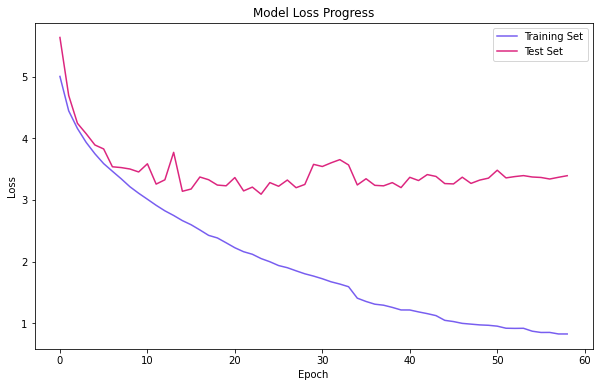

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

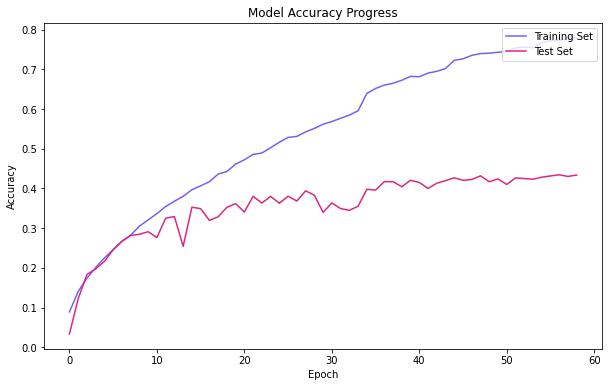

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

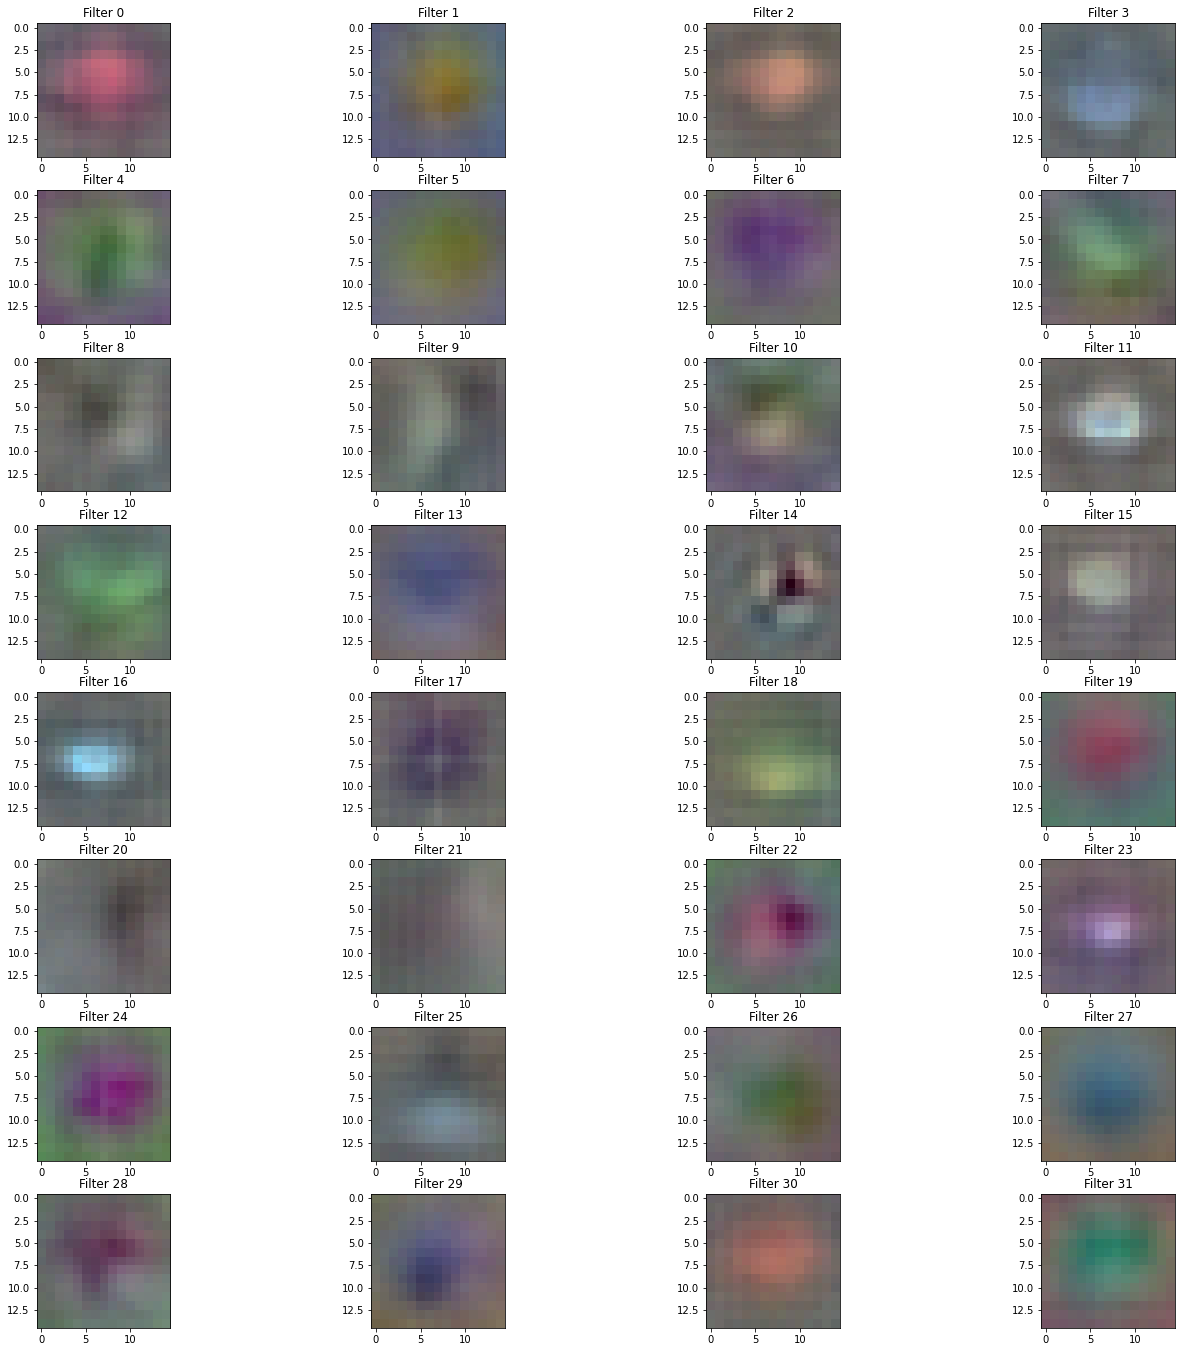

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("caltech256-{}-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

-0.9298137 1.3651747


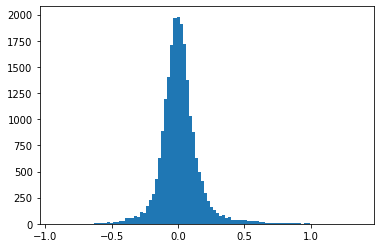

In [ ]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

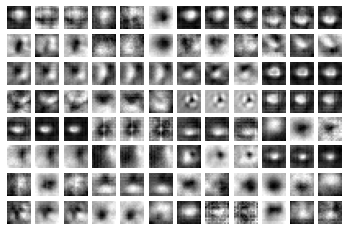

In [ ]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("caltech256-{}-channelwise-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [ ]:
!cp caltech256-1-history-kernel-15.p /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-loss-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-accuracy-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-channelwise-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/